# Finding a suitable neighbourhood in Bengaluru

## Loading all necessary libraries

In [1]:
import pandas as pd
import numpy as np
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins


/bin/bash: conda: command not found
/bin/bash: conda: command not found


In [3]:
pip install geopandas

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.4MB 10.3MB/s 
     |████████████████████████████████| 14.7MB 45.2MB/s 


In [4]:
import geopandas as gpd
print('Libraries imported.')

Libraries imported.


References : https://ksndmc.org:6443/arcgis/rest/services/BBMP/MapServer \n  https://www.kaggle.com/  \n https://github.com/datameet/Municipal_Spatial_Data/tree/master/Bangalore

To analyze :
flood prone areas\n
Water type\n
other Facilities\n

## Load Data into DataFrame



In [70]:
geo_df= gpd.read_file('/content/BBMP.GeoJSON')
print(geo_df.columns)
print('Shape - ', geo_df.shape)
print('unique - ',geo_df.ASS_CONST1.unique().shape)
geo_df.head(5)

#Removing unused columns
geo_df.drop(geo_df[['POP_M','POP_M','POP_SC','POP_ST','POP_F','AREA_SQ_KM','RESERVATIO','ASS_CONST_','OBJECTID']],axis=1,inplace = True)
geo_df.rename(columns={'WARD_NAME': 'Neighborhood','LAT':'Latitude','LON':'Longitude','ASS_CONST1':'AREA'}, inplace=True)
geo_df.to_csv(r'check_geo_data.csv',index=False,header=True)

Index(['OBJECTID', 'ASS_CONST_', 'ASS_CONST1', 'WARD_NO', 'WARD_NAME', 'POP_M',
       'POP_F', 'POP_SC', 'POP_ST', 'POP_TOTAL', 'AREA_SQ_KM', 'LAT', 'LON',
       'RESERVATIO', 'geometry'],
      dtype='object')
Shape -  (198, 15)
unique -  (27,)


In [71]:
geo_df.head()

AREA  ...                                           geometry
0   Yelahanka  ...  MULTIPOLYGON (((77.59229 13.09720, 77.59094 13...
1   Yelahanka  ...  MULTIPOLYGON (((77.56862 13.12705, 77.57064 13...
2   Yelahanka  ...  MULTIPOLYGON (((77.59094 13.09842, 77.59229 13...
3  K.R. Puram  ...  MULTIPOLYGON (((77.67683 13.01147, 77.67695 13...
4  K.R. Puram  ...  MULTIPOLYGON (((77.72899 13.02061, 77.72994 13...

[5 rows x 7 columns]

# Plot the neighbourhood on Map

### Find the lat and long of Bengaluru City

In [10]:
address = 'Bengaluru'

geolocator = Nominatim(user_agent="blr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bengaluru City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bengaluru City are 12.9791198, 77.5912997.


In [0]:
from branca.colormap import linear
colormap = linear.BuGn_09.scale(geo_df.POP_TOTAL.min(), geo_df.POP_TOTAL.max())
pop_dict=geo_df.set_index('Neighborhood')['POP_TOTAL']

In [0]:
#Define map styling function
def style_function(feature):
    pop_d = pop_dict.get(int(feature['id']), None)
    return {
        'fillColor': '#black' if pop_d is None else colormap(pop_d),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }

## Mark the area by Population

In [14]:
my_map= folium.Map([12.9724, 77.5806], zoom_start=12)

x=folium.GeoJson(
    geo_df,
    name='population',
    style_function=style_function,
    highlight_function= None,
    tooltip=(geo_df[i] for i in geo_df['POP_TOTAL'])
).add_to(my_map)
x.add_child(
folium.features.GeoJsonTooltip(['POP_TOTAL']))
folium.LayerControl().add_to(my_map)

my_map

# **Using FourSquare API to get details for each Neighbourhood**

## create a function to repeat for all the neighborhoods in Bengaluru

In [0]:
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

def getNearbyVenues(names, wardnos,latitudes, longitudes, radius=500):
    CLIENT_ID = 'F0GVKMQAUYBEFFDHAYRYHC3BCQEBJOE4HL3RJYJIBDW0JVB4' # your Foursquare ID
    CLIENT_SECRET = 'NAJLEIT1C2UCLKOSOWYMZTJHUMC502FTVJ24BYQU20NT14KS' # your Foursquare Secret
    VERSION='20180605'
    venues_list=[]
    for name, wardno,lat, lng in zip(names, wardnos,latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            wardno,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'WardNo',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('Total Venues = ',nearby_venues.shape)
    return(nearby_venues)

In [17]:
Bengaluru_venues = getNearbyVenues(names=geo_df['Neighborhood'],
                                   wardnos=geo_df['WARD_NO'],
                                   latitudes=geo_df['Latitude'],
                                   longitudes=geo_df['Longitude']
                                  )

Total Venues =  (1276, 8)


## Venues in the neighbourhood with lat and long

In [18]:
Bengaluru_venues.head(5)

Neighborhood  WardNo  ...  Venue Longitude     Venue Category
0                    Atturu     3.0  ...        77.560310                ATM
1                    Atturu     3.0  ...        77.559921  Electronics Store
2  Yelahanka Satellite Town     4.0  ...        77.582429       Dessert Shop
3  Yelahanka Satellite Town     4.0  ...        77.582664           Pharmacy
4  Yelahanka Satellite Town     4.0  ...        77.587242                ATM

[5 rows x 8 columns]

## Plotting the venue on the Map

In [19]:
blr_venues_map = folium.Map(location=[latitude, longitude],zoom_start=12, prefer_canvas=True )
fs = plugins.Fullscreen()
blr_venues_map.add_child(fs)

folium.GeoJson('/content/BBMP.GeoJSON').add_to(blr_venues_map)

# add markers to map for every venue
for lat, lng, venue, cat in zip(Bengaluru_venues['Venue Latitude'], Bengaluru_venues['Venue Longitude'], Bengaluru_venues['Venue'], Bengaluru_venues['Venue Category']):
    label = '{}: {}'.format(venue, cat)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
    ).add_to(blr_venues_map)  
blr_venues_map.save('Venues_in_Bengaluru.html')
blr_venues_map

# Clustering the Neighbourhoods

In [58]:
# one hot encoding of venue category
df_venues_onehot = pd.get_dummies(Bengaluru_venues[['Venue Category']], prefix="", prefix_sep="")

# add other columns back to the dataframe
df_venues_onehot['Neighborhood'] = Bengaluru_venues['Neighborhood']

# move those column to the first column
fixed_columns = list(df_venues_onehot.columns[-1:]) + list(df_venues_onehot.columns[:-1])
df_venues_onehot = df_venues_onehot[fixed_columns]

bengaluru_grouped = df_venues_onehot.groupby('Neighborhood').mean().reset_index()
bengaluru_grouped.head()

Neighborhood  ATM  Airport  ...  Watch Shop  Women's Store  Yoga Studio
0        A Narayanapura  0.0      0.0  ...         0.0            0.0          0.0
1               Adugodi  0.0      0.0  ...         0.0            0.0          0.0
2                Agaram  0.0      0.0  ...         0.0            0.0          0.0
3  Agrahara Dasarahalli  0.0      0.0  ...         0.0            0.0          0.0
4            Anjanapura  0.5      0.0  ...         0.0            0.0          0.0

[5 rows x 184 columns]

## K-Mean clustering

## Find optimal K value

maximum is 0.07165734378033822, which occurs at k=6


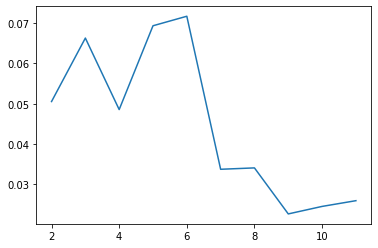

In [73]:
from sklearn import metrics
import matplotlib.pyplot as plt
START = 2
END = 12
scores = []
df_find_optimal = bengaluru_grouped.drop('Neighborhood',1);
for k in range(START, END):
    # run k-means clustering, but drop the first column 
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_find_optimal[df_find_optimal.columns[1:]])
    
    scores.append(metrics.silhouette_score(df_find_optimal, kmeans.labels_))   
print( "maximum is {}, which occurs at k={}".format(np.max(scores),np.argmax(scores)+START))
kclusters=np.argmax(scores)+START
plt.plot(range(START,END),scores)

The optimal K value is around K=4

In [24]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4

bengaluru_grouped_clustering = bengaluru_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bengaluru_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 2, 0, 1, 2, 2, 2, 1, 2], dtype=int32)

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Most common Venues category

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bengaluru_grouped['Neighborhood']

for ind in np.arange(bengaluru_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bengaluru_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood  ...       10th Most Common Venue
0        A Narayanapura  ...          Dumpling Restaurant
1               Adugodi  ...  Eastern European Restaurant
2                Agaram  ...          Dumpling Restaurant
3  Agrahara Dasarahalli  ...                  Event Space
4            Anjanapura  ...          Dumpling Restaurant

[5 rows x 11 columns]

Lets Merge the neighbourhood with Top 10 Venues

In [27]:
 kmeans.labels_

array([2, 0, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 3, 2, 2, 2, 0, 0, 2, 2, 0,
       3, 0, 3, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0,
       0, 2, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0,
       1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 0, 2, 1, 0, 1, 2, 2,
       2, 0, 2, 2, 0, 0, 1, 2, 0, 3, 2, 2, 2, 0, 1, 3, 2, 1, 2, 2, 2, 1,
       0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 0, 0, 0, 0, 2, 2,
       0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 3, 2, 0, 1, 0, 2, 0],
      dtype=int32)

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bengaluru_merged = geo_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bengaluru_merged = bengaluru_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bengaluru_merged = bengaluru_merged[bengaluru_merged['Cluster Labels'].notna()]
bengaluru_merged.shape # check the last columns!

(175, 18)

In [29]:
bengaluru_merged.head()

AREA  ...       10th Most Common Venue
1   Yelahanka  ...                  Dry Cleaner
2   Yelahanka  ...          Dumpling Restaurant
5  K.R. Puram  ...  Eastern European Restaurant
6  K.R. Puram  ...                  Dry Cleaner
7  K.R. Puram  ...          Dumpling Restaurant

[5 rows x 18 columns]

Lets Visualize our clusters

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12 , prefer_canvas=True)

fs = plugins.Fullscreen()
map_clusters.add_child(fs)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for name, cluster,shape in zip(bengaluru_merged['Neighborhood'], bengaluru_merged['Cluster Labels'].fillna(0.0).astype(int),bengaluru_merged['geometry']):
    geojson = folium.Choropleth(
        geo_data=shape,
        radius=7,
        fill_color=rainbow[cluster-1]
    )
    label = folium.Popup(name)
    label.add_to(geojson)
    geojson.add_to(map_clusters)
       
map_clusters.save('Bengaluru_Venue_clusters.html')
map_clusters

# Verify Clusters

In [31]:
clusters = pd.DataFrame(bengaluru_merged.groupby('Cluster Labels', as_index=False).apply(lambda x: ", ".join(x['Neighborhood'].tolist())), columns=['Similar'])
clusters['Count'] = bengaluru_merged.groupby('Cluster Labels')['Neighborhood'].count()
print("Cluster | Count | Neighbourhoods")
print("--------|-------|---------------")
for x,y,z in zip(clusters.index,clusters['Count'],clusters['Similar']):
    print("{}       | {}     | {}".format(x,y,z))

Cluster | Count | Neighbourhoods
--------|-------|---------------
0       | 65     | Hudi, Byatarayanapura, Yeshwanthpura, HMT Ward, Kottegepalya, Mattikere, Malleswaram, Kadu Malleshwar Ward, Gayithri Nagar, Hebbala, Vishwanath Nagenahalli, Gangenahalli, Jayachamarajendra Nagar, Kaval Bairasandra, Banasavadi, C V Raman Nagar, Jeevanbhima Nagar, Jayamahal, Bharathi Nagar, Shivaji Nagar, Shanthi Nagar, Jogupalya, Chickpete, Dattatreya Temple, Gandhinagar, Okalipuram, Shivanagara, Sriramamandir, Rajaji Nagar, Govindaraja Nagar, Agrahara Dasarahalli, Marenahalli, Mudalapalya, Nagarabhavi, Vijayanagar, Hampi Nagar, Bapuji Nagar, Gali Anjenaya Temple ward, K R Market, Chamrajapet, Sudham Nagara, Dharmaraya Swamy Temple, Sunkenahalli, Siddapura, Hombegowda Nagara, Basavanagudi, Karisandra, Yediyur, Lakkasandra, Adugodi, Suddagunte Palya, Sarakki, Jakkasandra, Byrasandra, Bellanduru, HSR Layout, Bommanahalli, Bilekhalli, Hongasandra, Konankunte, K R Puram, Jayanagar East, Vasanthpura, J P Nag

## Decision Tree

In [0]:
# training samples: Is there a venue of this type in this city?
X = df_venues_onehot.groupby(['Neighborhood']).max().reset_index().drop(['Neighborhood'],1).astype(int)

# class labels
Y = bengaluru_merged['Cluster Labels']

In [33]:
from sklearn import tree
blr_tree = tree.DecisionTreeClassifier(criterion='entropy' )
blr_tree = blr_tree.fit(X, Y)

df_topfeatures = pd.DataFrame({'Feature': X.columns.values, 'Importance':blr_tree.feature_importances_}).sort_values(by='Importance', ascending=False).head().reset_index()
df_topfeatures

index            Feature  Importance
0    132               Park    0.049234
1     96  Indian Restaurant    0.040939
2     27     Breakfast Spot    0.040052
3     90              Hotel    0.038700
4    169           Tea Room    0.034015

## Neighbourhood like Kammanahalli

In [34]:
bengaluru_merged[bengaluru_merged.Neighborhood == 'Kammanahalli']

AREA  WARD_NO  ...        9th Most Common Venue  10th Most Common Venue
69  Sarvagna Nagar     28.0  ...  Eastern European Restaurant     Dumpling Restaurant

[1 rows x 18 columns]

My place kammanahalli is in cluster 2, there are total 91 neighbourhood in cluster 2,

In [41]:
my_location_cluster = bengaluru_merged.loc[bengaluru_merged['Cluster Labels'] == 2]#, bengaluru_merged.columns[[1] + list(range(5, bengaluru_merged.shape[1]))]]
my_location_cluster.head()

AREA  ...  10th Most Common Venue
2         Yelahanka  ...     Dumpling Restaurant
6        K.R. Puram  ...             Dry Cleaner
7        K.R. Puram  ...     Dumpling Restaurant
10  Byatarayanapura  ...     Dumpling Restaurant
11  Byatarayanapura  ...     Dumpling Restaurant

[5 rows x 18 columns]

We will find Top 10 places that are close to my place

In [37]:
kammanahalli = bengaluru_merged.loc[69,:].drop('Neighborhood')
kammanahalli

AREA                                                         Sarvagna Nagar
WARD_NO                                                                  28
POP_TOTAL                                                             34819
Latitude                                                            13.0084
Longitude                                                            77.636
geometry                  (POLYGON ((77.63852853337006 13.01408143205299...
Cluster Labels                                                            2
1st Most Common Venue                                                 Diner
2nd Most Common Venue                                           Yoga Studio
3rd Most Common Venue                                            Donut Shop
4th Most Common Venue                                           Fish Market
5th Most Common Venue                                  Fast Food Restaurant
6th Most Common Venue                                        Farmers Market
7th Most Com

Plot the selected cluster in the map

In [43]:
# create map of the world using latitude and longitude values
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12 , prefer_canvas=True)

fs = plugins.Fullscreen()
map_clusters.add_child(fs)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for name, cluster,shape in zip(my_location_cluster['Neighborhood'], my_location_cluster['Cluster Labels'].fillna(0.0).astype(int),my_location_cluster['geometry']):
    geojson = folium.Choropleth(
        geo_data=shape,
        radius=7,
        fill_color=rainbow[cluster-1]
    )
    label = folium.Popup(name)
    label.add_to(geojson)
    geojson.add_to(map_clusters)
       
map_clusters.save('Bengaluru_My_clusters.html')
map_clusters

## Select Top 5 places like My Place(Kammanahalli)

In [63]:
kammanahalli = bengaluru_grouped.loc[69,:].drop('Neighborhood')
bengaluru_merged = bengaluru_merged.loc[bengaluru_merged['Cluster Labels'] == 2]
bengaluru_merged['d_kamman'] = bengaluru_grouped[bengaluru_grouped.columns[1:]].apply(lambda x: sum((kammanahalli - x)**2)**.5, axis=1)
top5 = bengaluru_merged.sort_values(by='d_kamman').head(5)
top5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


AREA  WARD_NO  ...       10th Most Common Venue  d_kamman
69      Sarvagna Nagar     28.0  ...          Dumpling Restaurant  0.000000
52              Hebbal     19.0  ...          Dumpling Restaurant  0.285342
15     Byatarayanapura      8.0  ...                  Dry Cleaner  0.303071
114  Govindaraja Nagar    126.0  ...            Electronics Store  0.304110
71      Sarvagna Nagar     30.0  ...  Eastern European Restaurant  0.304290

[5 rows x 19 columns]

## Making the Choice

In [69]:
features = df_topfeatures['Feature'].values.tolist()

#df_find_optimal = bengaluru_grouped.drop('Neighborhood',1);
top_neighborhood = pd.merge(top5, df_venues_onehot.groupby('Neighborhood').sum()[features], on='Neighborhood')[ ['Neighborhood'] + df_topfeatures['Feature'].values.tolist()]
top_neighborhood = top_neighborhood['Neighborhood'].copy()
top_neighborhood

0           Kammanahalli
1          Sanjaya Nagar
2            Kodigehalli
3    Maruthi Mandir ward
4       Kadugondanahalli
Name: Neighborhood, dtype: object

The above four places are close to my place Kammanahalli in terms of feature